In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import configs

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from models.networks_2022 import BranchedNetwork

# Parameters

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}1_checkpoints/'
tensorboard_dir = f'{engram_dir}1_tensorboard/'

In [20]:
base_activation_dir = f'{engram_dir}3_validation_activations/merged/'

In [21]:
activations_dirs = [
    f'{base_activation_dir}erm_ablation_merged/',
    f'{base_activation_dir}pnet_merged/'
    ]
axis_names = ['Error Term Ablation', 'No Ablation']

In [29]:
activations_dirs = [
    f'{base_activation_dir}fbm_ablation_merged/',
    f'{base_activation_dir}pnet_merged/'
    ]
axis_names = ['Feedback Ablation', 'No Ablation']

In [30]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cuda:0


# Function to collect accuracy values

In [31]:
def eval_accuracy(results):
    labels = np.array(results['label'])
    timesteps = []
    accuracies = []
    rel_accuracies = []
    ff_corrects = []
    clean_corrects = []
    
    n_timesteps = 5
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'{t}_output'][i]
            acc_t = (output == label).astype(float)
            if t == 0:
                ff_acc = acc_t
            rel_acc_t = acc_t - ff_acc
            timesteps.append(t)
            accuracies.append(acc_t)
            rel_accuracies.append(rel_acc_t)
            ff_corrects.append(ff_acc)
            clean_corrects.append(results['clean_correct'][i])

    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    rel_accuracies = np.array(rel_accuracies)
    ff_corrects = np.array(ff_corrects)
    clean_corrects = np.array(clean_corrects)
            
    return timesteps, accuracies, rel_accuracies, ff_corrects, clean_corrects

In [32]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [33]:
bgs = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snrs = [-9.0, -6.0, -3.0, 0.0, 3.0]

# Collect data

In [34]:
activ_dir

'/mnt/smb/locker/abbott-locker/hcnn/3_validation_activations/merged/pnet_merged/Babble8Spkr_snr3/'

In [35]:
activ_dir

'/mnt/smb/locker/abbott-locker/hcnn/3_validation_activations/merged/pnet_merged/Babble8Spkr_snr3/'

In [36]:
dfs = []
for activations_dir in activations_dirs:
    data = {}
    data['Accuracy'] = []
    data['Relative Accuracy'] = []

    # Shared by hyperparam set
    data['Timesteps'] = []
    data['SNR'] = []
    data['BG'] = []

    for bg in bgs:
        for snr in snrs:
            activ_dir = f'{activations_dir}{bg}_snr{int(snr)}/'
            if not os.path.isdir(activ_dir): continue
            for results_file in os.listdir(activ_dir):
                results_filepath = f'{activ_dir}{results_file}'
                results = h5py.File(results_filepath, 'r')
                timesteps, accs, rel_accs, ff_corrects, clean_corrects = eval_accuracy(results)
                accs *= 100
                rel_accs *= 100

                # Collect accuracy results by labels
                for t in [0, 1, 2, 3, 4]:
                    idxs = timesteps==t
                    rel_acc = np.mean(rel_accs[idxs])
                    data['Accuracy'].append(np.mean(accs[idxs]))
                    data['Relative Accuracy'].append(rel_acc)
                    data['Timesteps'].append(t)
                    data['SNR'].append(snr)
                    data['BG'].append(bg)
    df = pd.DataFrame(data)

    bg_avgs = {}
    for bg in np.unique(df['BG']):
        bg_avgs[bg] = {}
        for snr in np.unique(df['SNR']):
            bg_avgs[bg][snr] = np.mean(
                df[(df['BG'] == bg) & (df['SNR'] ==snr)]['Accuracy']
                )
    data['Relative Accuracy (BG Corrected)'] = []
    for idx in range(len(data['Accuracy'])):
        bg = data['BG'][idx]
        snr = data['SNR'][idx]
        rel_acc = data['Relative Accuracy'][idx]
        data['Relative Accuracy (BG Corrected)'].append(
            rel_acc/bg_avgs[bg][snr]
            )
    df = pd.DataFrame(data)
    dfs.append(df)

# Make Scatter

In [37]:
df0 = dfs[0]
df1 = dfs[1]

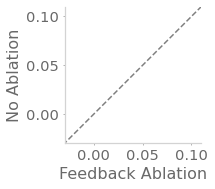

In [38]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_aspect('equal')
for bg in np.unique(dfs[0]['BG']):
    for snr in np.unique(dfs[0]['SNR']):
        val0 = np.mean(df0[(df0['BG']==bg) & (df0['SNR']==snr) & (df0['Timesteps']==4)]['Relative Accuracy (BG Corrected)'])
        val1 = np.mean(df1[(df1['BG']==bg) & (df1['SNR']==snr) & (df1['Timesteps']==4)]['Relative Accuracy (BG Corrected)'])
        ax.scatter(val0, val1, color='dimgray')
plt.ylim(-0.03, 0.11)
plt.xlim(-0.03, 0.11)
plt.plot([-0.1, 0.15], [-0.1, 0.15], color='gray', linestyle='--')
plt.xlabel(axis_names[0])
plt.ylabel(axis_names[1])
plt.xticks([0.0, 0.05, 0.1])
plt.yticks([0.0, 0.05, 0.1])
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('erm_ablation_scatter.png', dpi=300)
plt.show()